### Initialization
- Import modules
- Define file formatter
- Define plotters

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from utils import load_imputed_data

# folders and paths
imputed_data_folder = 'imputed_data'
initializations_folder = 'imputed_data_initializations'
metrics_folder = 'imputed_data_metrics'


def format_and_save(filename="metrics"):
    # Load imputed data
    imputed_data = load_imputed_data(imputed_data_folder)
    if not imputed_data: return

    # Convert to DataFrame
    imputed_data = pd.DataFrame(imputed_data)

    # Add (partial) header
    header = ['dataset', 'miss_rate', 'sparsity', 'init']
    for i in range(imputed_data.shape[1] - 4): header.append(f'rmse_{i}')
    imputed_data.columns = header

    # Calculate and append the RMSE mean and sd
    means = []
    sds = []
    for row in imputed_data.values:
        rmses = [float(n) for n in row[4:] if n is not None]
        means.append(f'{np.mean(rmses):.4f}')
        sds.append(f'{np.std(rmses):.7f}')

    imputed_data['rmse_mean'] = means
    imputed_data['rmse_sd'] = sds

    # Calculate the FLOPS
    # Todo

    # Append the success_rate
    saf = pd.read_csv(f'{metrics_folder}/successes_and_failures.csv')
    for dataset, miss_rate, sparsity, init, successes, failures in saf.values:
        success_rate = (successes / (successes + failures))
        failure_rate = 1 - success_rate
        imputed_data.loc[
            (imputed_data['dataset'] == dataset)
            & (imputed_data['miss_rate'].astype('float') == miss_rate)
            & (imputed_data['sparsity'].astype('float') == sparsity)
            & (imputed_data['init'] == init), ['successes', 'failures', 'success_rate', 'failure_rate']
        ] = successes, failures, f'{success_rate:.4f}', f'{failure_rate:.4f}'

    # Sort the data by: dataset, init, miss_rate, sparsity (*in order of priority)
    imputed_data.sort_values(['dataset', 'init', 'miss_rate', 'sparsity'], inplace=True)

    # Save the formatted file
    imputed_data.to_csv(f'{metrics_folder}/{filename}.csv', index=False)

    return imputed_data


def plot_rmse(metrics, CI, save=False):
    def _normz(val):
        return st.norm.ppf((1 + val) / 2)

    # Assuming normal (two-tailed) distribution
    z = _normz(CI)
    CI = int(CI * 100)
    n_runs = metrics.shape[1] - 10  # Todo: set to 11 when FLOPs are added

    # Create plots for every different dataset and miss_rate, group by initialization
    for dataset_miss_rate, dataset_group in metrics.groupby(['dataset', 'miss_rate']):
        dataset, miss_rate = dataset_miss_rate[0], int(float(dataset_miss_rate[1]) * 100)

        plt.figure()
        init_legend = {}
        for init, init_group in dataset_group.groupby(['init']):
            init = init[0]
            if init == 'ER': init = 'Erdos Renyi'

            x = init_group['sparsity'].astype('float')
            y = init_group['rmse_mean'].astype('float')
            e = init_group['rmse_sd'].astype('float') * z

            if init == 'dense':
                y_mu = y.iloc[0]
                y_sigma = y_mu - e.iloc[0], y_mu + e.iloc[0]
                line = plt.axhline(y=y_mu, color='black', linewidth=1)
                plt.axhline(y=y_sigma[0], color='black', linewidth=1, linestyle='--')
                plt.axhline(y=y_sigma[1], color='black', linewidth=1, linestyle='--')
                init_legend[init] = line
            else:
                line = plt.errorbar(x, y, e, marker='o', markersize=3, capsize=5, elinewidth=1, label=init)
                plt.fill_between(x, y - e, y + e, alpha=0.2)
                init_legend[init] = line

        plt.title(f'{dataset}: {miss_rate}% missing data ({n_runs} runs)'
                  f'\nRMSE v sparsity, grouped by initialization, CI: {CI}%')
        plt.xlabel('sparsity level')
        plt.ylabel('RMSE')
        plt.legend(init_legend.values(), init_legend.keys(), title='Initializations', loc='upper left')
        plt.grid(True)

        if save:
            path = f'{metrics_folder}/RMSE_{dataset}_missrate_{miss_rate/100}.png'
            plt.savefig(path)

        plt.show()


def plot_failure_rate(metrics):
    pass


def plot_FLOPs(metrics):
    pass


def plot_accuracy(metrics):
    pass

### Format and save the results

In [3]:
metrics = format_and_save()

### Plot RMSE, failure_rate, FLOPs and accuracy

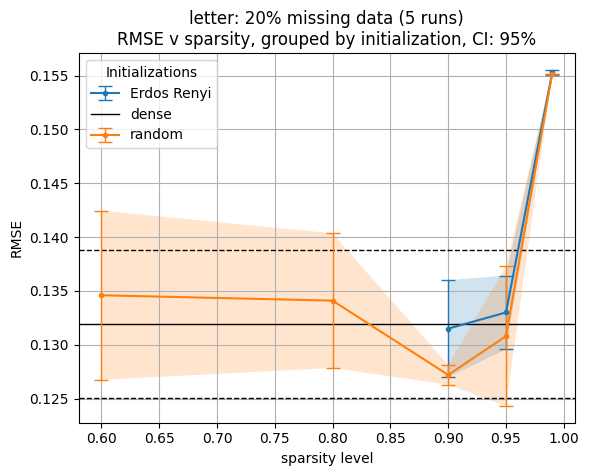

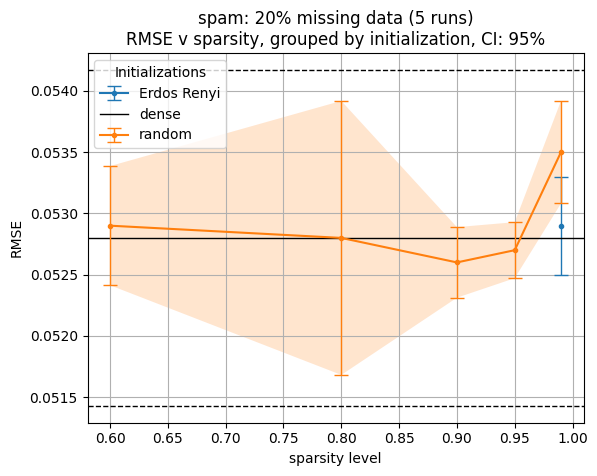

In [4]:
plot_rmse(metrics, 0.95, save=True)